In [2]:
! curl 'https://api.ipify.org?format=text'

174.127.218.226

In [10]:
!pip install xgboost

    100% |████████████████████████████████| 501kB 1.0MB/s ta 0:00:01
  Running setup.py bdist_wheel for xgboost ... done
  Stored in directory: /Users/marcusdemaster/Library/Caches/pip/wheels/4e/6d/1d/0bc23240225fe411315d8abb5d4521b9ff002493ff77515ccc
Successfully built xgboost
You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [23]:
import psycopg2

# Test Connection
conn = psycopg2.connect(user='postgres', password='MIDSw210SDOH',
                        host='35.199.151.123', port='5432')
cursor = conn.cursor()
print ('Connected!')

cursor.execute("""with tweets as (	
                    select distinct
                    u.handle,
                    u.label,
                    u.marker_tweet,
                    u.search_phrase,
                    h.tweet_text,
                    case when d.gender='Male' then 1 else 0 end as ismale,
                    round(log(d.follower_count+1)*100) as follower_count,
                    round(log(d.favorites_count+1)*100) as favorites_count,
                    round(log(d.friends_count+1)*100) as friends_count,
                    d.bot_likelihood*100 as bot_likelihood_int,
                    (cast(d.latitude as float)+90.0)*1000000 as zeroed_lat,
                    (cast(d.longitude as float)+180.0)*1000000 as zeroed_long
                    from sdoh_model_user u
                    left join sdoh_model_user_tweet_history h on u.handle=h.handle
                    left join sdoh_model_user_profile_detail d on u.handle=d.handle
                    where substring(tweet_text,1,2)!='RT' and 
                    (cast(h.tweet_datetime as date)-cast(u.marker_tweet_datetime as date))<=365 and
                    d.bot_likelihood<0.5 and u.sdoh_model='employment'
                    )
                    select distinct 
                    t.handle,
                    t.label,
                    string_agg(t.tweet_text, '; ') as tweets,
                    t.ismale,
                    t.follower_count,
                    t.favorites_count,
                    t.friends_count,
                    t.bot_likelihood_int,
                    t.zeroed_lat,
                    t.zeroed_long
                    from tweets t,(select handle,count(tweet_text) as tweet_count from tweets group by handle) c
                    where t.handle=c.handle and c.tweet_count between 30 and 100
                
                                    group by 
                                    t.handle,
                                    t.label,
                                    t.ismale,
                                    t.follower_count,
                                    t.favorites_count,
                                    t.friends_count,
                                    t.bot_likelihood_int,
                                    t.zeroed_lat,
                                    t.zeroed_long"""
                    )
#and date_part('YEAR',u.marker_tweet_datetime)>=2017
riskgroup = cursor.fetchall()
print(len(riskgroup))

# close communication with the PostgreSQL database server
cursor.close()
# commit the changes
conn.commit()

Connected!
2628


In [24]:
import re
from textblob import TextBlob

def clean_tweet(tweet):
    no_symbol = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())
    lower_case = no_symbol.lower()
    return remove_links(lower_case)
    
def analyze_polarity(tweet):
    analysis = TextBlob(clean_tweet(tweet))
    return analysis.sentiment.polarity
  
def analyze_subjectivity(tweet):
    analysis = TextBlob(clean_tweet(tweet))
    return analysis.sentiment.subjectivity
    
def remove_links(tweet):#http, Http, HTTP, ssh, ftp, www, etc.
    return re.sub(r'((http|https|ssh|ftp|www)|\w+\.\w+).*?( |$)', '', tweet, flags=re.IGNORECASE) 

In [25]:
import json
import keras
import keras.preprocessing.text as kpt
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential,InputLayer
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Dense, Dropout, Activation,Flatten
from keras.layers import Embedding

labels = np.array([x[1] for x in riskgroup])
tweets = [x[2] for x in riskgroup]

# only work with the 3000 most popular words found in our dataset
max_features = 3000

# create a new Tokenizer
tokenizer = Tokenizer(num_words=max_features)

# feed our tweets to the Tokenizer
tokenizer.fit_on_texts(tweets)

# Tokenizers come with a convenient list of words and IDs
dictionary = tokenizer.word_index

# Let's save this out so we can use it later
with open('dictionary.json', 'w') as dictionary_file:
    json.dump(dictionary, dictionary_file)

def convert_text_to_index_array(text):
    # one really important thing that `text_to_word_sequence` does
    # is make all texts the same length -- in this case, the length
    # of the longest text in the set.
    return [dictionary[word] for word in kpt.text_to_word_sequence(text)]

allWordIndices = []
# for each tweet, change each token to its ID in the Tokenizer's word_index
for text in tweets:
    wordIndices = convert_text_to_index_array(text)
    allWordIndices.append(wordIndices)

# now we have a list of all tweets converted to index arrays.
# cast as an array for future usage.
allWordIndices = np.asarray(allWordIndices)

# create one-hot matrices out of the indexed tweets
tweets = tokenizer.sequences_to_matrix(allWordIndices, mode='binary')

# treat the labels as categories
labels = keras.utils.to_categorical(labels, 2)

model = Sequential()
model.add(Dense(512, input_shape=(max_features,), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

history = model.fit(tweets, labels,
    batch_size=32,
    epochs=2,
    verbose=1,
    validation_split=0.1,
    shuffle=True)

model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)

model.save_weights('model.h5')

print('saved model!')

Train on 2365 samples, validate on 263 samples
Epoch 1/2
2365/2365 [==============================] - 4s 2ms/step - loss: 0.7764 - acc: 0.5459 - val_loss: 0.6285 - val_acc: 0.6312
Epoch 2/2
2365/2365 [==============================] - 3s 1ms/step - loss: 0.6522 - acc: 0.6173 - val_loss: 0.6796 - val_acc: 0.6312
saved model!


In [26]:
from pandas import DataFrame
import pandas as pd

traindata= DataFrame(data=riskgroup,columns=[
    "handle",
    "label",
    "tweets",
    "ismale",
    "follower_count",
    "favorites_count",
    "friends_count",
    "bot_likelihood_int",
    "zeroed_lat",
    "zeroed_long"
])
traindata["pol"]=traindata.apply(lambda row: analyze_polarity(row["tweets"]), axis=1)
traindata["subj"]=traindata.apply(lambda row: analyze_subjectivity(row["tweets"]), axis=1)


nn_preds = DataFrame(data=model.predict(tweets),columns=["pred0","pred1"])
m_traindata= pd.concat([traindata, nn_preds], axis=1)



In [27]:
from sklearn_pandas import DataFrameMapper
trainmapper = DataFrameMapper([
     ('pred0', None),
     ('pred1', None),
    ('ismale', None),
    ('follower_count', None),
    ('favorites_count', None),
    ('subj', None),
    ('pol', None),
    ('bot_likelihood_int', None),
    ('friends_count', None),
 ])

X = trainmapper.fit_transform(m_traindata)
Y = np.array(m_traindata['label'])




In [28]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
from xgboost import XGBClassifier as XGBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import cross_validation as cv
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
xgb=XGBoostClassifier(seed=123)
rf=RandomForestClassifier()
ab=AdaBoostClassifier()
gb=GradientBoostingClassifier()
et=ExtraTreesClassifier()
lr=LogisticRegression()

model_list=[xgb,rf,ab,gb,et,lr]
model_names=['XGBoost','RandomForest','AdaBoost','GradientBoost','ExtraTrees','LogisticRegression']
metrics=['accuracy','f1']

accuracy=[]
f1=[]
for clf,name in zip(model_list,model_names):
    accuracy.append(round(np.mean(cv.cross_val_score(clf, X, Y,cv=10, scoring='accuracy')),4))
    f1.append(round(np.mean(cv.cross_val_score(clf, X, Y,cv=10, scoring='f1')),4))





In [29]:
modelframe = DataFrame(model_names,columns=["Model Type"])
accuracyframe = DataFrame(data=accuracy,columns=["Accuracy"])
f1frame = DataFrame(data=f1,columns=["F1 Score"])
modelresultsframe = pd.concat([modelframe,accuracyframe,f1frame], axis=1)
modelresultsframe

,Model Type,Accuracy,F1 Score
0,XGBoost,0.8287,0.7915
1,RandomForest,0.8081,0.7702
2,AdaBoost,0.8222,0.7840
3,GradientBoost,0.8268,0.7888
4,ExtraTrees,0.8131,0.7621
5,LogisticRegression,0.8268,0.7768


In [30]:
import psycopg2

# Test Connection
conn = psycopg2.connect(user='postgres', password='MIDSw210SDOH',
                        host='35.199.151.123', port='5432')
cursor = conn.cursor()



cursor.execute("""with tweets as (	
                    select distinct
                    u.handle,
                    u.marker_tweet,
                    u.search_phrase,
                    u.disease_population,
                    h.tweet_text,
                    case when d.gender='Male' then 1 else 0 end as ismale,
                    round(log(d.follower_count+1)*100) as follower_count,
                    round(log(d.favorites_count+1)*100) as favorites_count,
                    round(log(d.friends_count+1)*100) as friends_count,
                    d.bot_likelihood*100 as bot_likelihood_int,
                    (cast(d.latitude as float)+90.0)*1000000 as zeroed_lat,
                    (cast(d.longitude as float)+180.0)*1000000 as zeroed_long
                    from disease_subject_user u
                    left join disease_subject_user_tweet_history h on u.handle=h.handle
                    left join disease_subject_user_profile_detail d on u.handle=d.handle
                    where substring(tweet_text,1,2)!='RT'
                    
                    )
                    select distinct 
                    t.handle,
                    string_agg(t.tweet_text, '; ') as tweets,
                    t.ismale,
                    t.follower_count,
                    t.favorites_count,
                    t.friends_count,
                    t.bot_likelihood_int,
                    t.zeroed_lat,
                    t.zeroed_long,
                    t.disease_population
                    from tweets t,(select handle,count(tweet_text) as tweet_count from tweets group by handle) c
                    where t.handle=c.handle and c.tweet_count between 30 and 100
                                    group by 
                                    t.handle,
                                    t.ismale,
                                    t.follower_count,
                                    t.favorites_count,
                                    t.friends_count,
                                    t.bot_likelihood_int,
                                    t.zeroed_lat,
                                    t.zeroed_long,
                                    t.disease_population
                    """)
disease_data= cursor.fetchall()
print(len(disease_data))

disease_tweets = []
for tweet_d in disease_data:
    disease_tweets.append(tweet_d[1])

5599


In [31]:
def get_probs(tweets):
    words = kpt.text_to_word_sequence(tweets)
    wordIndices = []
    for word in words:
        if word in dictionary:
            wordIndices.append(dictionary[word])
    
    input_ = tokenizer.sequences_to_matrix([wordIndices], mode='binary')
    score = model.predict(input_).tolist()
    return score

In [32]:
from pandas import DataFrame
import pandas as pd


diseaseframe= DataFrame(data=disease_data,columns=[
    "handle",
    "tweets",
    "ismale",
    "follower_count",
    "favorites_count",
    "friends_count",
    "bot_likelihood_int",
    "zeroed_lat",
    "zeroed_long",
    "disease_population"
])

# diseaseframe["disease_label"]=diseaseframe.apply(lambda row: renamecolumn(row["disease_population"]), axis=1)
diseaseframe["pred0"]=diseaseframe.apply(lambda row: get_probs(row["tweets"])[0][0], axis=1)
diseaseframe["pred1"]=diseaseframe.apply(lambda row: get_probs(row["tweets"])[0][1], axis=1)

diseaseframe["pol"]=diseaseframe.apply(lambda row: analyze_polarity(row["tweets"]), axis=1)
diseaseframe["subj"]=diseaseframe.apply(lambda row: analyze_subjectivity(row["tweets"]), axis=1)

In [33]:
X_target = trainmapper.fit_transform(diseaseframe)

xgb=XGBoostClassifier(seed=123).fit(X,Y)
xgbframe = DataFrame(data=np.array(xgb.predict_proba(X_target))[:,1].tolist(),columns=["xgb_scores"])

rf=RandomForestClassifier().fit(X,Y)
rfframe = DataFrame(data=np.array(rf.predict_proba(X_target))[:,1].tolist(),columns=["rf_scores"])

ab=AdaBoostClassifier().fit(X,Y)
abframe = DataFrame(data=np.array(ab.predict_proba(X_target))[:,1].tolist(),columns=["ab_scores"])

gb=GradientBoostingClassifier().fit(X,Y)
gbframe = DataFrame(data=np.array(gb.predict_proba(X_target))[:,1].tolist(),columns=["gb_scores"])

et=ExtraTreesClassifier().fit(X,Y)
etframe = DataFrame(data=np.array(et.predict_proba(X_target))[:,1].tolist(),columns=["et_scores"])

lr=LogisticRegression().fit(X,Y)
lrframe = DataFrame(data=np.array(lr.predict_proba(X_target))[:,1].tolist(),columns=["lr_scores"])


finalframe= pd.concat([diseaseframe, xgbframe, rfframe, abframe, gbframe, etframe, lrframe], axis=1)

In [34]:
score_summary=finalframe[['disease_population','xgb_scores','rf_scores','ab_scores','gb_scores','et_scores','lr_scores']].groupby('disease_population').mean()
score_summary

,xgb_scores,rf_scores,ab_scores,gb_scores,et_scores,lr_scores
disease_population,,,,,,
adhd,0.369664,0.367925,0.492859,0.372413,0.393711,0.371856
breast_cancer,0.273642,0.304308,0.489629,0.291802,0.273077,0.283038
cholesterol,0.345841,0.358577,0.494645,0.347207,0.348954,0.348924
clinical_depression,0.430419,0.432110,0.497242,0.429500,0.422018,0.419798
copd,0.307297,0.323957,0.489991,0.317255,0.306337,0.314522
heart_disease,0.315154,0.326220,0.490403,0.325066,0.300813,0.312825
hypertension,0.300115,0.306250,0.492790,0.302456,0.302009,0.303457
lung_cancer,0.362121,0.368931,0.493602,0.369797,0.361838,0.366816
type2diabetes,0.310321,0.331812,0.491215,0.325207,0.309986,0.317525


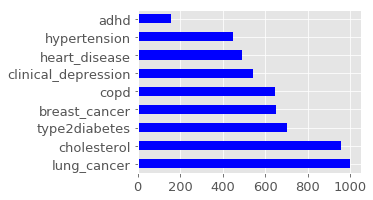

In [35]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

ax = finalframe['disease_population'].value_counts().plot(kind='barh', figsize=(4,3),
                                        color="blue", fontsize=13);

In [36]:
meanframe=finalframe[['disease_population','lr_scores']].groupby('disease_population').mean().round(3)
countframe=finalframe[['disease_population','handle']].groupby('disease_population').count()
meancountframe=pd.concat([meanframe, countframe], axis=1)
meancountframe

,lr_scores,handle
disease_population,,
adhd,0.372,159
breast_cancer,0.283,650
cholesterol,0.349,956
clinical_depression,0.420,545
copd,0.315,647
heart_disease,0.313,492
hypertension,0.303,448
lung_cancer,0.367,1001
type2diabetes,0.318,701


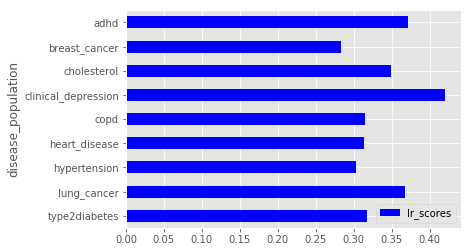

In [37]:
finalframe[['handle','disease_population','lr_scores']].groupby('disease_population').mean().plot(kind='barh',color='blue').invert_yaxis()

In [ ]:
#Upload scores to psql database

# # Test Connection
# conn = psycopg2.connect(user='postgres', password='MIDSw210SDOH',
#                         host='35.199.151.123', port='5432')
# cursor = conn.cursor()

# seen_handle = []
# for i, row in finalframe.iterrows():
#   handle= row['handle']
#   if handle not in seen_handle:
#     seen_handle.append(handle)
#     score = row['lr_scores']
#     disease=row['disease_population']
#     sdoh_factor='Healthcare Access'
#     handle_sdoh=handle+'_'+sdoh_factor
#     final = (handle_sdoh, handle, score, disease, sdoh_factor)
#     cursor.execute("""INSERT INTO sdoh_final_scores (handle_sdoh, handle, sdoh_factor,disease_category,score) VALUES (%s, %s, %s, %s, %s)""",[handle_sdoh,handle,sdoh_factor,disease,score])
#     if i % 1000 == 0:
#       print(i)
#       print(final)

# print('Done')
# # # close communication with the PostgreSQL database server
# cursor.close()
# # # commit the changes
# conn.commit()